In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:3]

['emma', 'olivia', 'ava']

In [3]:
#build the vocab of chars and mappings to integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# build the dataset
block_size = 3
def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])
        

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:

class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) #/ fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        #parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        #buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True, unbiased=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta] 

class Tanh:

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 100  #hidden layer
g  = torch.Generator().manual_seed(2147729)
C  = torch.randn((vocab_size, n_embd),              generator=g)
# layers = [
#     Linear(n_embd * block_size, n_hidden, bias=False), Tanh(),
#     Linear(           n_hidden, n_hidden, bias=False), Tanh(),
#     Linear(           n_hidden, n_hidden, bias=False), Tanh(),
#     Linear(           n_hidden, n_hidden, bias=False), Tanh(),
#     Linear(           n_hidden, n_hidden, bias=False), Tanh(),
#     Linear(           n_hidden, vocab_size, bias=False),  
# ]
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size), 
]

with torch.no_grad():
    # last layer: make less confident
    # layers[-1].weight *= 0.1
    layers[-1].gamma *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


47024


In [6]:
# Optimazation
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)  #random indices
    Xb, Yb = Xtr[ix], Ytr[ix]

    #forward pass -----------
    emb = C[Xb]  #embed characters into vectors
    x = emb.view(emb.shape[0], -1)  #concatanate the vectors or flatten
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)


    #backward pass ---------------
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.5 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:  # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f} :lr={lr}")
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

    # break
    if i > 1000:
        break






      0/ 200000: 3.3460 :lr=0.5


layer 2 (      Tanh): mean -0.00, std 0.63, satured:  3%
layer 5 (      Tanh): mean -0.01, std 0.63, satured:  2%
layer 8 (      Tanh): mean +0.00, std 0.63, satured:  2%
layer 11 (      Tanh): mean +0.00, std 0.63, satured:  2%
layer 14 (      Tanh): mean +0.00, std 0.64, satured:  3%


Text(0.5, 1.0, 'activation distribution')

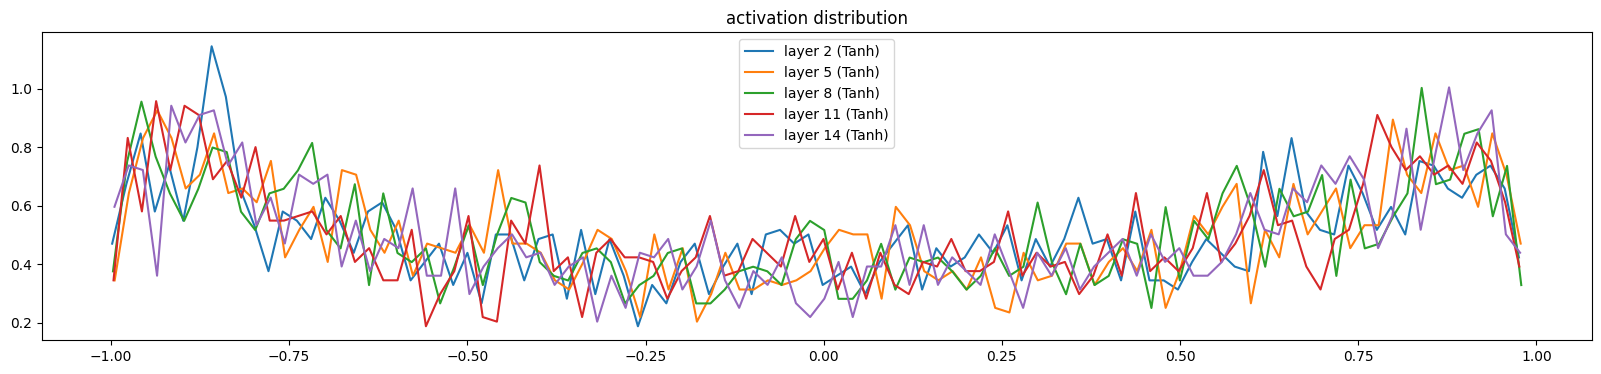

In [7]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, satured: %2.f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 4.505537e-03
layer 5 (      Tanh): mean +0.000000, std 4.086419e-03
layer 8 (      Tanh): mean +0.000000, std 3.752920e-03
layer 11 (      Tanh): mean -0.000000, std 3.461258e-03
layer 14 (      Tanh): mean -0.000000, std 3.129959e-03


Text(0.5, 1.0, 'gradient distribution')

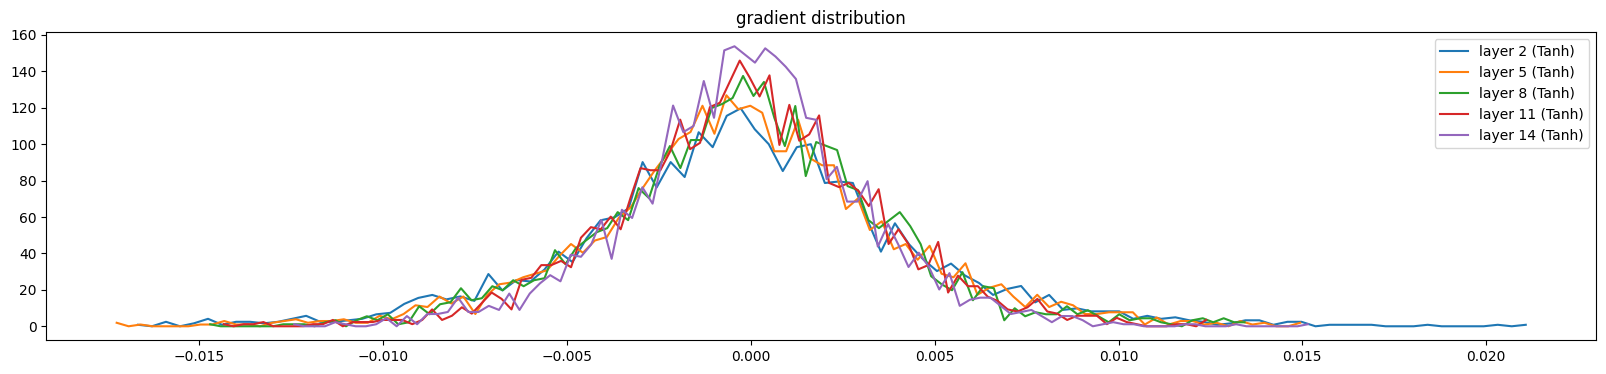

In [8]:
# gradient distribution
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 1.112512e-02 | grad:data ratio 1.064679e-02
weight  (30, 100) | mean -0.000056 | std 3.319256e-03 | grad:data ratio 3.335370e-03
weight (100, 100) | mean +0.000006 | std 1.538696e-03 | grad:data ratio 1.532456e-03
weight (100, 100) | mean -0.000001 | std 1.376670e-03 | grad:data ratio 1.381336e-03
weight (100, 100) | mean -0.000002 | std 1.148973e-03 | grad:data ratio 1.139884e-03
weight (100, 100) | mean -0.000006 | std 1.032615e-03 | grad:data ratio 1.037764e-03
weight  (100, 27) | mean -0.000004 | std 1.754935e-03 | grad:data ratio 1.731994e-03


Text(0.5, 1.0, 'visualize histograms')

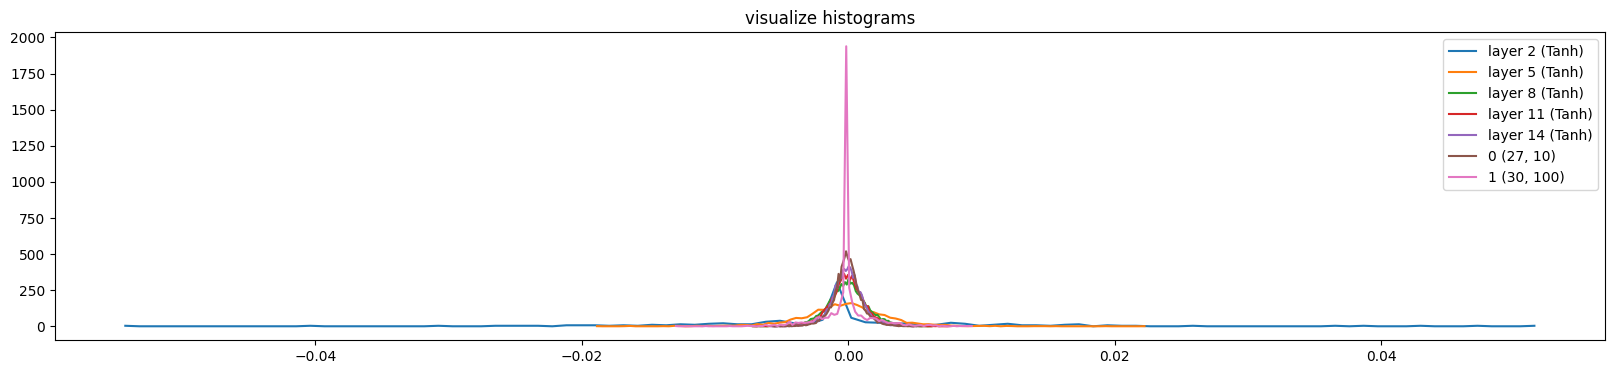

In [9]:
# visualize histograms
plt.figure(figsize=(20,4))
legentds = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')

plt.legend(legends)
plt.title('visualize histograms')

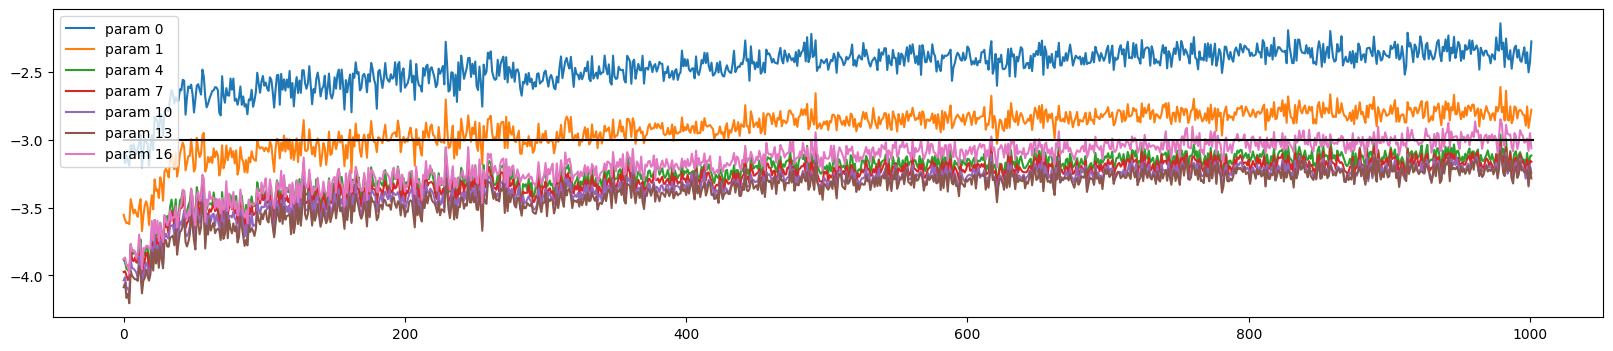

In [10]:
plt.figure(figsize=(20,4))
legends=[]
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3,-3], 'k')
plt.legend(legends);


In [11]:
@torch.no_grad()  #disable gradient tracking

def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

# put layers into eval mode
for layer in layers:
    layer.training = False
split_loss('train')
split_loss('val')

train 2.4452078342437744
val 2.4397428035736084


In [12]:
# sample from the model

g = torch.Generator().manual_seed(2123123)

for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]  #l, blocksize, n_embed
        x = emb.view(emb.shape[0], -1)
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

zakverbyvliylo.
rim.
chazusexi.
irh.
talacdamirtyychledyn.
ffon.
reed.
armasilo.
jedhaci.
cen.
zen.
ayarahyae.
cwen.
taelaaey.
sralimahiz.
hanmoqmormaeline.
lel.
jiusiwa.
toni.
mil.


In [2]:
# !pip install ipywidgets

interactive(children=(FloatSlider(value=0.0, description='x0', max=30.0, min=-30.0, step=0.5), Output()), _dom…

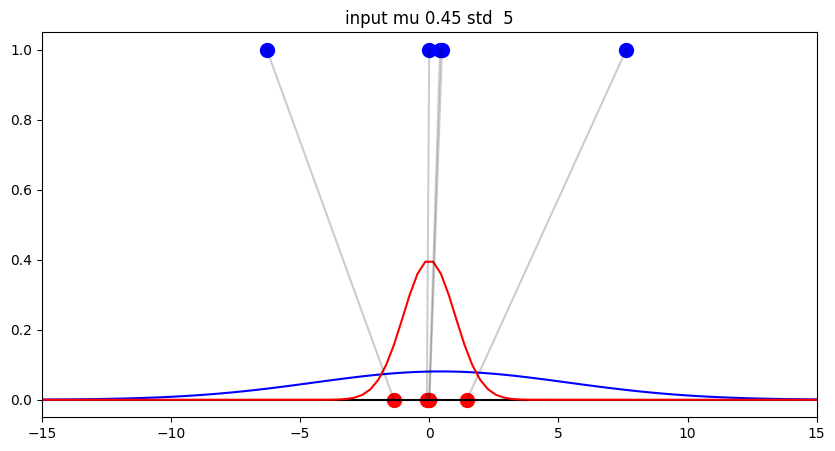

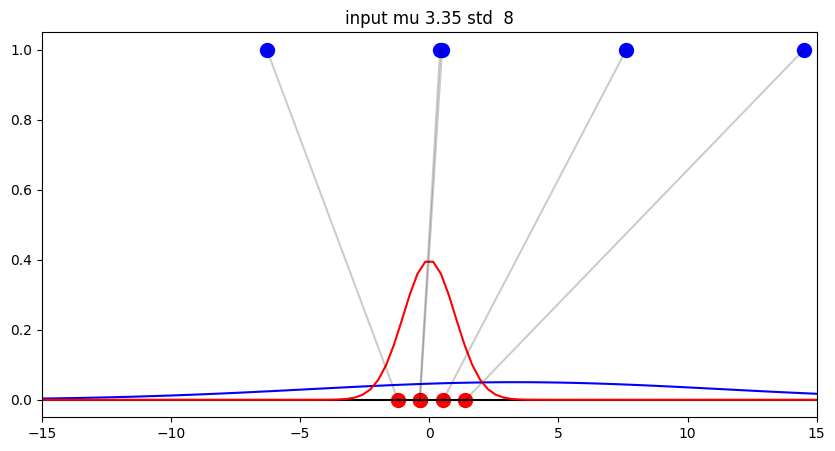

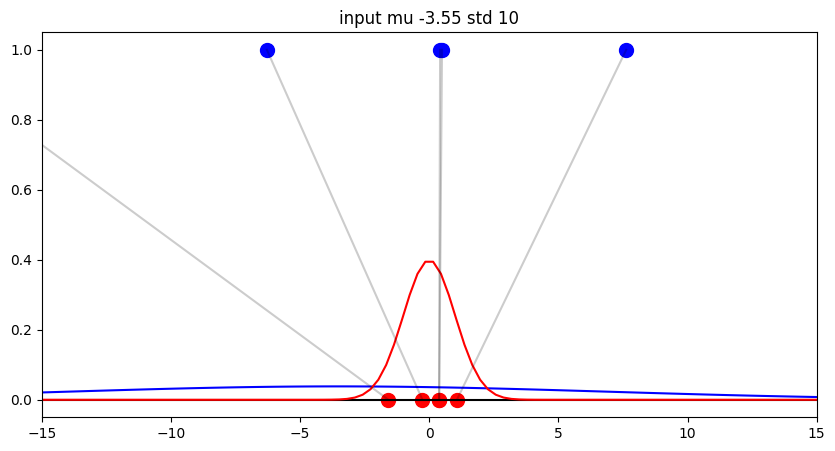

In [28]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stats
import numpy as np

def normshow(x0):

    g = torch.Generator().manual_seed(214789283)
    x = torch.randn(5, generator=g) * 5
    print("x=", x)
    x[0] = x0
    print("aftx=", x)
    mu = x.mean()
    sig = x.std()
    y = (x-mu)/sig
    print("y=", y)

    plt.figure(figsize=(10, 5))
    plt.plot([-15, 15], [0,0], 'k')
    xx = np.linspace(-15, 15, 100)
    plt.plot(xx, stats.norm.pdf(xx, mu, sig), 'b')
    xx = np.linspace(-15, 15, 100)
    plt.plot(xx, stats.norm.pdf(xx, 0, 1), 'r')
    for i in range(len(x)):
        plt.plot([x[i], y[i]], [1,0], 'k', alpha=0.2)
    plt.scatter(x.data, torch.ones_like(x).data, c='b', s=100)
    plt.scatter(y.data, torch.zeros_like(y).data, c='r', s=100)
    plt.xlim(-15, 15)

    plt.title('input mu %.2f std %2.f' % (mu, sig))

interact(normshow, x0=(-30, 30, 0.5));

In [38]:
# ativation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

a = torch.randn((1000, 1), requires_grad=True, generator=g)
b = torch.randn((1000, 1000), requires_grad=True, generator=g)
c = b @ a
loss = torch.randn(1000, generator=g) @ c
a.retain_grad()
b.retain_grad()
c.retain_grad()
loss.backward()
print('a std:', a.std().item())
print('b std:', b.std().item())
print('c std:', c.std().item())
print('-----')
print('c grad shape:', c.grad.shape)
print('a grad shape:', a.grad.shape)
print('b grad shape:', b.grad.shape)
print('-----')
print('c grad std:', c.grad.std().item())
print('a grad std:', a.grad.std().item())
print('b grad std:', b.grad.std().item())

#This tells us the output activations grow with the square root of input dimensionality, 
# a key reason for careful initialization in deep networks.

a std: 0.9875972270965576
b std: 1.0006722211837769
c std: 31.01241683959961
-----
c grad shape: torch.Size([1000, 1])
a grad shape: torch.Size([1000, 1])
b grad shape: torch.Size([1000, 1000])
-----
c grad std: 0.9782556295394897
a grad std: 30.8818302154541
b grad std: 0.9666601419448853


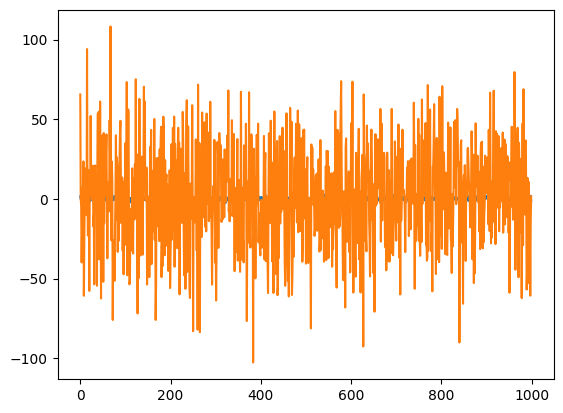

In [37]:
plt.plot(a.view(-1).tolist())
# plt.plot(b.view(-1).tolist())
plt.plot(c.view(-1).tolist())

In [21]:
# linear + batchnorm activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

n = 1000
inp = torch.randn(n, requires_grad=True, generator=g)
w = torch.randn((n, n), requires_grad=True, generator=g)
x = w @ inp

xmean = x.mean()
xvar = x.var()
out = (x - xmean) / torch.sqrt(xvar + 1e-5)

loss = out @ torch.randn(n, generator=g)
inp.retain_grad()
x.retain_grad()
w.retain_grad()
out.retain_grad()
loss.backward()

print('inp std: ', inp.std().item())
print('w std: ', w.std().item())
print('x std: ', x.std().item())
print('out std: ', out.std().item())
print('------')
print('out grad std: ', out.grad.std().item())
print('x grad std: ', x.grad.std().item())
print('w grad std: ', w.grad.std().item())
print('inp grad std: ', inp.grad.std().item())

inp std:  0.9875972270965576
w std:  1.0006722211837769
x std:  31.01241683959961
out std:  1.0
------
out grad std:  0.9782556295394897
x grad std:  0.031543977558612823
w grad std:  0.031169468536973
inp grad std:  0.9953053593635559
